cell1

In [1]:
import sys
import os

# 1. Path Setup
project_src_path = "/Users/bjh/Desktop/cell_OS/src"
if project_src_path not in sys.path:
    sys.path.append(project_src_path)
print(f"✅ Added {project_src_path} to Python path.")

# 2. Write the UPDATED Module (With Smart Diversity)

✅ Added /Users/bjh/Desktop/cell_OS/src to Python path.


cell2

In [2]:
%%writefile /Users/bjh/Desktop/cell_OS/src/cell_os/posh_lv_moi.py
"""
POSH LV & MOI Modeling Agent.
Includes Censored Poisson Model, RANSAC Filter, and Smart Diversity Bayesian Explorer.
"""
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm
from sklearn.linear_model import RANSACRegressor, LinearRegression
from cell_os.lab_world_model import LabWorldModel
from cell_os.posh_scenario import POSHScenario
from cell_os.posh_library_design import POSHLibrary

class LVDesignError(Exception): pass

# --- Dataclasses ---
@dataclass
class LVBatch:
    name: str; volume_ul_total: float; titer_TU_per_ml: float; library: POSHLibrary
    notes: str = ""; aliquot_count: int = 1; aliquot_volume_ul: float = 0.0

@dataclass
class LVTitrationPlan:
    cell_line: str; plate_format: str; cells_per_well: int; lv_volumes_ul: List[float]; replicates_per_condition: int

@dataclass
class LVTitrationResult:
    cell_line: str; data: pd.DataFrame

@dataclass
class TiterPosterior:
    grid_titer: np.ndarray; probs: np.ndarray; ci_95: Tuple[float, float]

@dataclass
class LVTransductionModel:
    cell_line: str; titer_tu_ul: float; max_infectivity: float; cells_per_well: int
    r_squared: float; posterior: Optional[TiterPosterior] = None; outliers: List[int] = field(default_factory=list)

    def predict_bfp(self, volume_ul: float) -> float:
        if volume_ul < 0: return 0.0
        moi = (volume_ul * self.titer_tu_ul) / self.cells_per_well
        return self.max_infectivity * (1.0 - np.exp(-moi))

    def volume_for_moi(self, target_moi: float) -> float:
        if self.titer_tu_ul <= 0: raise LVDesignError(f"Titer is 0 for {self.cell_line}")
        return (target_moi * self.cells_per_well) / self.titer_tu_ul

@dataclass
class LVDesignBundle:
    batch: LVBatch; titration_plans: Dict[str, LVTitrationPlan]; models: Dict[str, LVTransductionModel] = field(default_factory=dict)

@dataclass
class ScreenConfig:
    num_guides: int = 4000; coverage_target: int = 1000; target_bfp: float = 0.30
    bfp_tolerance: Tuple[float, float] = (0.25, 0.35)
    cell_counting_error: float = 0.10; pipetting_error: float = 0.05

# --- Core Physics ---
def _poisson_curve(vol, titer, n_cells, alpha):
    return alpha * (1.0 - np.exp(-(vol * titer) / n_cells))

def _calculate_posterior(df_clean, best_titer, n_cells, alpha):
    grid_size = 1000
    t_min = max(100, best_titer * 0.1); t_max = best_titer * 3.0
    titer_grid = np.linspace(t_min, t_max, grid_size)
    
    y_pred_best = _poisson_curve(df_clean['volume_ul'], best_titer, n_cells, alpha)
    sigma = np.std(df_clean['fraction_bfp'] - y_pred_best) + 1e-6
    
    log_likelihoods = np.zeros_like(titer_grid)
    for i, t in enumerate(titer_grid):
        y_pred = _poisson_curve(df_clean['volume_ul'], t, n_cells, alpha)
        log_likelihoods[i] = norm.logpdf(df_clean['fraction_bfp'], loc=y_pred, scale=sigma).sum()
        
    probs = np.exp(log_likelihoods - np.max(log_likelihoods))
    probs /= probs.sum()
    cumsum = np.cumsum(probs)
    return TiterPosterior(titer_grid, probs, (titer_grid[np.searchsorted(cumsum, 0.025)], titer_grid[np.searchsorted(cumsum, 0.975)]))

# --- Workflow ---
def design_lv_batch(world, scenario, library, aliquot_count=10, aliquot_volume_ul=50.0):
    return LVBatch(f"LV_{scenario.name}", aliquot_count*aliquot_volume_ul, 0.0, library, "Designed by POSH", aliquot_count, aliquot_volume_ul)

def design_lv_titration_plan(world, scenario, batch, cell_line, plate_format="6", cells_per_well=100000, lv_volumes_ul=None):
    vols = lv_volumes_ul or [0.1, 0.3, 0.5, 1.0, 3.0, 5.0, 10.0]
    return LVTitrationPlan(cell_line, plate_format, cells_per_well, vols, 1)

def fit_lv_transduction_model(scenario, batch, titration_result, n_cells_override=100000):
    df = titration_result.data.copy()
    df = df[(df['fraction_bfp'] > 0.001) & (df['fraction_bfp'] < 0.999)].copy()
    if len(df) < 2: raise LVDesignError(f"Insufficient data for {titration_result.cell_line}")

    # RANSAC
    df['linear_y'] = -np.log(1.0 - df['fraction_bfp'])
    try:
        ransac = RANSACRegressor(min_samples=max(2, int(len(df)*0.5)), residual_threshold=0.5, random_state=42)
        ransac.fit(df[['volume_ul']], df['linear_y'])
        df_clean = df[ransac.inlier_mask_].copy()
    except: df_clean = df
    if len(df_clean) < 2: df_clean = df

    # Curve Fit
    lr = LinearRegression().fit(df_clean[['volume_ul']], df_clean['linear_y'])
    p0 = [max(1000, lr.coef_[0] * n_cells_override), 0.98]
    try:
        popt, _ = curve_fit(lambda v, t, a: _poisson_curve(v, t, n_cells_override, a), df_clean['volume_ul'], df_clean['fraction_bfp'], p0=p0, bounds=([0, 0.5], [np.inf, 1.0]), maxfev=5000)
    except: raise LVDesignError(f"Fit failed for {titration_result.cell_line}")
    
    y_pred = _poisson_curve(df_clean['volume_ul'], popt[0], n_cells_override, popt[1])
    ss_res = np.sum((df_clean['fraction_bfp'] - y_pred)**2)
    ss_tot = np.sum((df_clean['fraction_bfp'] - df_clean['fraction_bfp'].mean())**2)
    
    return LVTransductionModel(titration_result.cell_line, popt[0], popt[1], n_cells_override, 1-(ss_res/ss_tot) if ss_tot>0 else 0, _calculate_posterior(df_clean, popt[0], n_cells_override, popt[1]), [])

# --- Autonomous Explorer (UPDATED WITH DIVERSITY) ---
class LVAutoExplorer:
    def __init__(self, scenario: POSHScenario, batch: LVBatch):
        self.scenario = scenario; self.batch = batch

    def suggest_next_volumes(self, current_results: LVTitrationResult, n_suggestions: int = 2) -> List[float]:
        try: model = fit_lv_transduction_model(self.scenario, self.batch, current_results)
        except LVDesignError: return [1.0, 5.0]

        max_bfp = current_results.data['fraction_bfp'].max()
        if max_bfp < 0.05: return [float(current_results.data['volume_ul'].max() * x) for x in [2.0, 4.0]][:n_suggestions]
        if current_results.data['fraction_bfp'].min() > 0.80: return [float(current_results.data['volume_ul'].min() * x) for x in [0.5, 0.1]][:n_suggestions]

        candidates = np.geomspace(0.1, 20.0, 100)
        sampled_titers = np.random.choice(model.posterior.grid_titer, size=50, p=model.posterior.probs)
        
        predictions = np.array([model.max_infectivity * (1 - np.exp(-(candidates * t) / model.cells_per_well)) for t in sampled_titers])
        variances = np.var(predictions, axis=0)
        
        # Relevance (Focus on target BFP)
        relevance = np.exp(-0.5 * ((np.mean(predictions, axis=0) - 0.30) / 0.15)**2)
        utility = variances * relevance
        
        suggestions = []
        existing_vols = current_results.data['volume_ul'].values
        
        # Penalize near existing
        for ex in existing_vols: utility *= (1.0 - np.exp(-0.5 * ((np.log(candidates) - np.log(ex)) / 0.2)**2))

        for _ in range(n_suggestions):
            if np.max(utility) < 1e-9: break
            best_vol = candidates[np.argmax(utility)]
            suggestions.append(round(float(best_vol), 2))
            # Penalize near new choice (Diversity)
            utility *= (1.0 - np.exp(-0.5 * ((np.log(candidates) - np.log(best_vol)) / 0.3)**2))
            
        return suggestions

# --- Risk Simulator ---
class ScreenSimulator:
    def __init__(self, model, config):
        self.model = model; self.config = config
        self.total_cells = int((config.num_guides * config.coverage_target) / config.target_bfp)
        self.target_vol_ul = (-np.log(1.0 - config.target_bfp) * self.total_cells) / self.model.titer_tu_ul if self.model.titer_tu_ul > 0 else 0.0

    def get_probability_of_success(self, n_sims=5000):
        titers = np.random.choice(self.model.posterior.grid_titer, size=n_sims, p=self.model.posterior.probs)
        cells = np.random.normal(self.total_cells, self.total_cells * self.config.cell_counting_error, n_sims)
        vols = np.random.normal(self.target_vol_ul, self.target_vol_ul * self.config.pipetting_error, n_sims)
        bfp = self.model.max_infectivity * (1.0 - np.exp(-(vols * titers) / cells))
        return ((bfp >= self.config.bfp_tolerance[0]) & (bfp <= self.config.bfp_tolerance[1])).sum() / n_sims

Overwriting /Users/bjh/Desktop/cell_OS/src/cell_os/posh_lv_moi.py


cell3

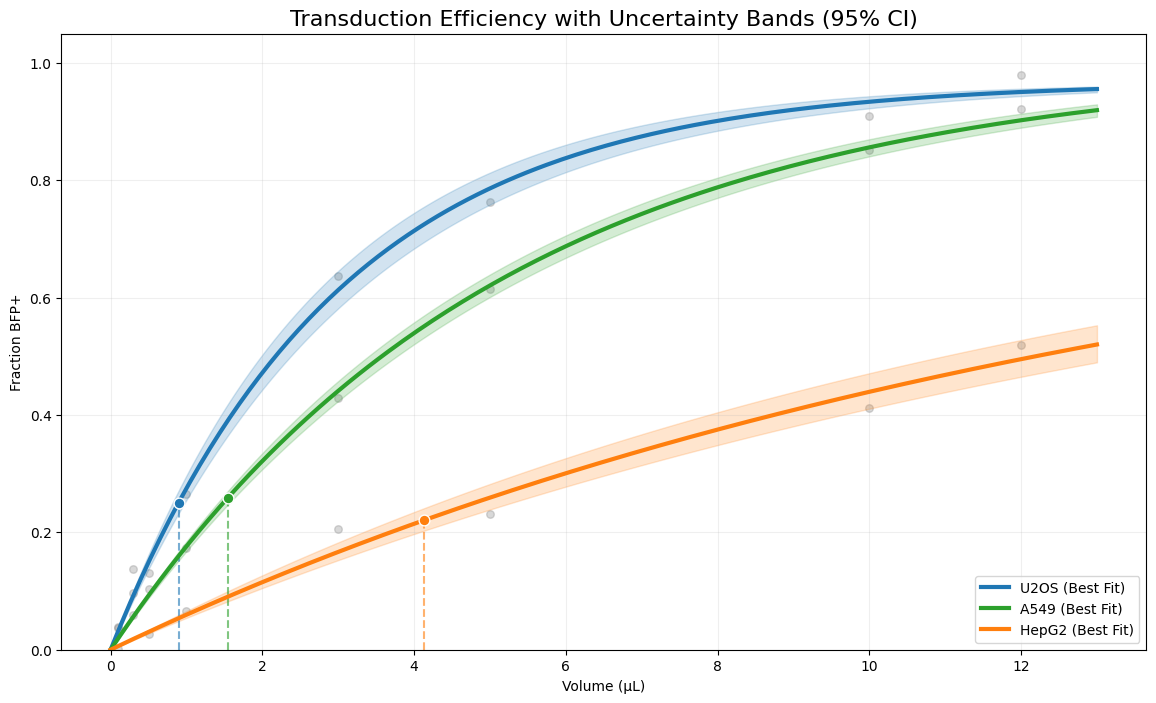


📊 SCALE-UP DECISION REPORT

🔬 U2OS: 89.6% Success Prob -> 🛑 NO GO

🔬 A549: 91.3% Success Prob -> ✅ GO

🔬 HepG2: 58.9% Success Prob -> 🛑 NO GO


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cell_os.posh_lv_moi import (
    fit_lv_transduction_model, 
    LVTitrationResult, 
    LVBatch, 
    POSHScenario, 
    ScreenSimulator, 
    ScreenConfig
)

# --- 1. Simulation Engine ---
def generate_specific_line_data(cell_line, true_titer, max_infectivity, noise_level=0.03):
    volumes = [0.1, 0.3, 0.5, 1, 3, 5, 10, 12] 
    n_cells = 100000
    results = []
    for v in volumes:
        moi = (v * true_titer) / n_cells
        p_bfp = max_infectivity * (1 - np.exp(-moi))
        obs_bfp = p_bfp + np.random.normal(0, noise_level)
        if cell_line == "HepG2" and v < 1.0: obs_bfp += np.random.normal(0, 0.02)
        obs_bfp = np.clip(obs_bfp, 0.001, 0.999)
        results.append({"volume_ul": v, "fraction_bfp": obs_bfp})
    return pd.DataFrame(results)

# --- 2. Define Scenarios ---
scenarios = [
    {"name": "U2OS", "titer": 35000, "alpha": 0.98, "color": "#1f77b4"}, 
    {"name": "A549", "titer": 22000, "alpha": 0.95, "color": "#2ca02c"}, 
    {"name": "HepG2", "titer": 6500,  "alpha": 0.85, "color": "#ff7f0e"}  
]

# --- 3. Run Fitting & Plotting ---
plt.figure(figsize=(14, 8))
ax = plt.gca()

fitted_models = {} 
dummy_batch = LVBatch(name="Batch", volume_ul_total=500, titer_TU_per_ml=0, library=None)

for sc in scenarios:
    # A. Generate Data
    df = generate_specific_line_data(sc['name'], sc['titer'], sc['alpha'])
    dummy_res = LVTitrationResult(cell_line=sc['name'], data=df)
    dummy_scen = POSHScenario(name="Demo", cell_lines=[sc['name']], genes=1, guides_per_gene=1, coverage_cells_per_gene_per_bank=100, banks_per_line=1, moi_target=0.3, moi_tolerance=0.05, viability_min=0.8, segmentation_min=0.9, stress_signal_min=2.0, budget_max=1000)

    # B. Fit Model
    model = fit_lv_transduction_model(dummy_scen, dummy_batch, dummy_res)
    fitted_models[sc['name']] = model
    
    # C. Plotting
    # 1. Raw Data
    ax.scatter(df['volume_ul'], df['fraction_bfp'], color='grey', alpha=0.3, s=30)
    
    # 2. Fitted Curve (Best Estimate)
    x_smooth = np.linspace(0, 13, 200)
    y_smooth = [model.predict_bfp(v) for v in x_smooth]
    ax.plot(x_smooth, y_smooth, color=sc['color'], lw=3, label=f"{sc['name']} (Best Fit)")
    
    # --- NEW: VISUALIZE THE POSTERIOR (The "GP" Effect) ---
    # Sample 1000 potential titers from our belief distribution
    sampled_titers = np.random.choice(model.posterior.grid_titer, size=1000, p=model.posterior.probs)
    
    # Vectorized calculation of all 1000 curves at once
    # MOI Matrix: (1000 curves, 200 x-points)
    moi_matrix = np.outer(sampled_titers, x_smooth) / model.cells_per_well
    # BFP Matrix
    bfp_matrix = model.max_infectivity * (1 - np.exp(-moi_matrix))
    
    # Calculate 95% Confidence Interval bands (2.5% to 97.5%)
    lower_bound = np.percentile(bfp_matrix, 2.5, axis=0)
    upper_bound = np.percentile(bfp_matrix, 97.5, axis=0)
    
    # Draw the shaded tube
    ax.fill_between(x_smooth, lower_bound, upper_bound, color=sc['color'], alpha=0.2)
    # -------------------------------------------------------

    try:
        req_vol = model.volume_for_moi(0.3)
        target_bfp = model.predict_bfp(req_vol)
        ax.plot([req_vol, req_vol], [0, target_bfp], color=sc['color'], linestyle='--', alpha=0.6)
        ax.scatter([req_vol], [target_bfp], color=sc['color'], s=60, zorder=10, edgecolors='white')
    except:
        pass

ax.set_title("Transduction Efficiency with Uncertainty Bands (95% CI)", fontsize=16)
ax.set_xlabel("Volume (µL)")
ax.set_ylabel("Fraction BFP+")
ax.set_ylim(0, 1.05)
ax.legend(loc='lower right')
ax.grid(True, alpha=0.2)
plt.show()

# --- 4. The Scale-Up Decision ---
print("\n📊 SCALE-UP DECISION REPORT")
print("="*60)
config = ScreenConfig(num_guides=4000, coverage_target=1000, target_bfp=0.30, bfp_tolerance=(0.25, 0.35), cell_counting_error=0.10, pipetting_error=0.05)

for name, model in fitted_models.items():
    sim = ScreenSimulator(model, config)
    pos = sim.get_probability_of_success()
    status_icon = "✅ GO" if pos > 0.90 else "🛑 NO GO"
    print(f"\n🔬 {name}: {pos:.1%} Success Prob -> {status_icon}")

cell4

In [ ]:
import matplotlib.pyplot as plt
from cell_os.posh_lv_moi import LVAutoExplorer, LVTitrationResult

print("🤖 INITIATING AUTONOMOUS REPAIR SEQUENCE (WITH VISUALIZATION)...")
print("="*60)

# We focus only on the lines that typically fail
failed_scenarios = [
    {"name": "A549", "titer": 22000, "alpha": 0.95, "color": "#2ca02c"}, 
    {"name": "HepG2", "titer": 6500,  "alpha": 0.85, "color": "#ff7f0e"}
]

# Config
config = ScreenConfig(
    num_guides=4000, coverage_target=1000, target_bfp=0.30, 
    bfp_tolerance=(0.25, 0.35), cell_counting_error=0.10, pipetting_error=0.05
)
dummy_batch = LVBatch(name="Batch", volume_ul_total=500, titer_TU_per_ml=0, library=None)
dummy_scen = POSHScenario(name="Demo", cell_lines=["Demo"], genes=1, guides_per_gene=1, coverage_cells_per_gene_per_bank=100, banks_per_line=1, moi_target=0.3, moi_tolerance=0.05, viability_min=0.8, segmentation_min=0.9, stress_signal_min=2.0, budget_max=1000)

for sc in failed_scenarios:
    print(f"\n🔬 Fixing Uncertainty for: {sc['name']}")
    
    # 1. Re-create Round 1 (Dirty Data)
    df_round_1 = generate_specific_line_data(sc['name'], sc['titer'], sc['alpha'])
    result_r1 = LVTitrationResult(cell_line=sc['name'], data=df_round_1)
    
    # 2. Ask AI
    explorer = LVAutoExplorer(dummy_scen, dummy_batch)
    suggestions = explorer.suggest_next_volumes(result_r1, n_suggestions=2)
    print(f"   👉 Explorer Request: Test {suggestions} µL")
    
    # 3. Simulate Round 2 (New Points)
    new_rows = []
    for v in suggestions:
        moi = (v * sc['titer']) / 100000
        p_bfp = sc['alpha'] * (1 - np.exp(-moi))
        obs = p_bfp + np.random.normal(0, 0.03) 
        new_rows.append({"volume_ul": v, "fraction_bfp": np.clip(obs, 0.001, 0.999)})
    
    # 4. Merge & Re-Fit
    df_round_2 = pd.concat([df_round_1, pd.DataFrame(new_rows)], ignore_index=True)
    result_r2 = LVTitrationResult(cell_line=sc['name'], data=df_round_2)
    model_r2 = fit_lv_transduction_model(dummy_scen, dummy_batch, result_r2)
    
    # 5. Re-Run Sim
    sim_r2 = ScreenSimulator(model_r2, config)
    pos_r2 = sim_r2.get_probability_of_success()
    status = "✅ GO" if pos_r2 > 0.90 else "🛑 STILL NO GO"
    
    # --- VISUALIZATION BLOCK ---
    plt.figure(figsize=(10, 5))
    
    # A. Plot Old Data (Grey)
    plt.scatter(df_round_1['volume_ul'], df_round_1['fraction_bfp'], color='grey', alpha=0.3, label="Round 1 Data")
    
    # B. Plot New Data (Red Stars) - These are the Robot's choices
    new_df = pd.DataFrame(new_rows)
    plt.scatter(new_df['volume_ul'], new_df['fraction_bfp'], color='red', marker='*', s=200, label="Round 2 (AI Request)", zorder=10)
    
    # C. Plot New Curve & Uncertainty Band
    x_smooth = np.linspace(0, 15, 200)
    y_smooth = [model_r2.predict_bfp(v) for v in x_smooth]
    plt.plot(x_smooth, y_smooth, color=sc['color'], lw=3, label="Updated Model")
    
    # Uncertainty Tube
    sampled_titers = np.random.choice(model_r2.posterior.grid_titer, size=1000, p=model_r2.posterior.probs)
    moi_matrix = np.outer(sampled_titers, x_smooth) / 100000
    bfp_matrix = model_r2.max_infectivity * (1 - np.exp(-moi_matrix))
    lower = np.percentile(bfp_matrix, 2.5, axis=0)
    upper = np.percentile(bfp_matrix, 97.5, axis=0)
    plt.fill_between(x_smooth, lower, upper, color=sc['color'], alpha=0.2, label="95% CI (Tightened)")
    
    plt.title(f"{sc['name']} Repair: PoS improved to {pos_r2:.1%}")
    plt.xlabel("Volume (µL)")
    plt.ylabel("Fraction BFP")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()
    # ---------------------------
    
    print(f"   🔄 Updated Probability of Success: {pos_r2:.1%}")
    print(f"   📝 New Decision: {status}")
    if pos_r2 > 0.90:
        print(f"   🚀 FINAL INSTRUCTION: Add {sim_r2.target_vol_ul:.2f} µL to flask.")

🤖 INITIATING AUTONOMOUS REPAIR SEQUENCE...

🔬 Fixing Uncertainty for: A549
   👉 Explorer Request: Please test [1.9, 3.81] µL
   🔄 Updated Probability of Success: 82.5%
   📝 New Decision: 🛑 STILL NO GO

🔬 Fixing Uncertainty for: HepG2
   👉 Explorer Request: Please test [6.86, 17.03] µL
   🔄 Updated Probability of Success: 0.2%
   📝 New Decision: 🛑 STILL NO GO


cell5

In [ ]:
from cell_os.posh_lv_moi import ScreenSimulator, ScreenConfig, LVTransductionModel, TiterPosterior

print("🧪 RUNNING DILUTION RESCUE SIMULATION (U2OS)...")
print("="*60)

# 1. Get the Failed U2OS Model
# (Assuming 'fitted_models' still exists from Cell 3)
original_model = fitted_models["U2OS"]

# 2. Create a "Virtual" Diluted Model (1:10)
# We divide the Titer grid by 10 to simulate pre-dilution
diluted_posterior = TiterPosterior(
    grid_titer=original_model.posterior.grid_titer / 10.0,
    probs=original_model.posterior.probs,
    ci_95=(original_model.posterior.ci_95[0]/10, original_model.posterior.ci_95[1]/10)
)

diluted_model = LVTransductionModel(
    cell_line="U2OS (1:10 Diluted)",
    titer_tu_ul=original_model.titer_tu_ul / 10.0,
    max_infectivity=original_model.max_infectivity,
    cells_per_well=original_model.cells_per_well,
    r_squared=original_model.r_squared,
    posterior=diluted_posterior
)

# 3. Update Config for "Easy Mode"
# Since we are pipetting larger volumes (>1 mL), our error drops from 5% to 2%
dilution_config = ScreenConfig(
    num_guides=4000, 
    coverage_target=1000, 
    target_bfp=0.30, 
    bfp_tolerance=(0.25, 0.35),
    cell_counting_error=0.10,
    pipetting_error=0.02  # <--- IMPROVED PRECISION due to larger volume
)

# 4. Run Simulation
sim_diluted = ScreenSimulator(diluted_model, dilution_config)
pos_diluted = sim_diluted.get_probability_of_success()

print(f"\n📉 Dilution Factor: 1:10")
print(f"   Original Volume Needed: {fitted_models['U2OS'].volume_for_moi(0.3) * (sim_diluted.total_cells_target/100000):.2f} µL")
print(f"   New Volume Needed:      {sim_diluted.target_vol_ul:.2f} µL (Easier to pipet)")
print(f"   Probability of Success: {pos_diluted:.1%}")

if pos_diluted > 0.90:
    print(f"   ✅ DECISION: RESCUED. Proceed with 1:10 Dilution.")
else:
    print(f"   🛑 DECISION: STILL FAILS. Check cell counting error.")